In [1]:
# we first load the class module

import dipolarBECnb

In [2]:
# necessary python modules

from tqdm import tqdm
import numpy as np
import os
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.special import kn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl        
mpl.rcParams['text.usetex'] = True
import seaborn
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

pal = seaborn.color_palette("tab10")
print(pal.as_hex())

# if seaborn does not work, try: pip install seaborn

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [3]:
#check which interaction is used and save fig in the appropriate subfolder

fv = 'd'  # 'd' or 'NN'

path_dict = {
    'd': "C:\\Users\\camipolv\\Desktop\\dipbec\\fig\\dipnb\\",
    'NN': "C:\\Users\\camipolv\\Desktop\\dipbec\\fig\\NNnb\\"
}

fpath = path_dict.get(fv, "Default path")

Ust = r"$U_{NN}$" if fv == "NN" else r"$U_d$" if fv == "d" else None
Ucs = r"$/U_c$"

In [36]:
#parameters

Ndisr = 100
Nmesh = 100

N0 = 10
#N1 = 10
#N2 = 100
#N3 = 500

kx_small = 0.1 #0.01
kx_large_dict = {'d': 10.0, 'NN': 25.0}
kx_large = kx_large_dict.get(fv, "Default value")

Uc = 1.0

#NN: Ud << Uc/2, d: Ud << Uc/3
Ud1_dict = {'d': 0.0, 'NN': 0.0}
Ud2_dict = {'d': 0.1, 'NN': 0.1}
Ud3_dict = {'d': 0.3, 'NN': 0.3}
Ud1 = Ud1_dict.get(fv, "Default value")
Ud2 = Ud2_dict.get(fv, "Default value")
Ud3 = Ud3_dict.get(fv, "Default value")

sigma1 = 0.0
sigma2 = 0.2
sigma3 = 0.5

t0 = 1.0
t1 = 2.0
t2 = 5.0
t3 = 10.0

t_dict = {'d': np.arange(0, t2, .1), 'NN': np.arange(0, t1, .01)}
tdar = t_dict.get(fv, "Default value")

kxs = [kx_small, kx_large]
kxar = np.linspace(kx_small, kx_large, Nmesh)
sigmas = [sigma1, sigma2, sigma3]
nb = np.random.uniform(1-sigmas[1], 1+sigmas[1], N0)
print(nb)
nbs = [np.random.uniform(1-s, 1+s, N0) for s in sigmas]
print(nbs)
Sigmar = np.linspace(sigma1, sigma3, 10)
nbars = [np.random.uniform(1-s, 1+s, N0) for s in Sigmar]
Uds = [Ud1, Ud2, Ud3]
Udar = np.linspace(Ud1, Ud3, 10)
Ntar = np.asarray([2, 4, 6, 8, 10])
nbnars = [np.random.uniform(1-sigmas[1], 1+sigmas[1], n) for n in Ntar]
#Ntar = np.asarray([10, 50, 100, 150, 200, 250, 500])#, 1000])

markers = ['s', 'o', '^']

print(Ust + r" = {}, {}, {}".format(Ud1, Ud2, Ud3))
print(f"kx = {kx_small}, {kx_large}")
print(tdar)

[0.9169789  0.89043762 1.00753732 0.92065865 0.99647295 0.93331326
 0.92588111 1.09320911 0.81222339 1.02733797]
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1.01317311, 0.91932025, 0.85746421, 0.90483905, 0.87355904,
       1.10575458, 0.923643  , 0.902921  , 0.91778596, 1.09648877]), array([0.83586138, 1.4417597 , 0.81663695, 0.95712812, 0.97485573,
       1.26397755, 1.16290572, 1.28957443, 1.26764115, 0.53572706])]
$U_d$ = 0.0, 0.1, 0.3
kx = 0.1, 10.0
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]


In [41]:
for i in range(len(sigmas)):
    print(nbs[i])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.01317311 0.91932025 0.85746421 0.90483905 0.87355904 1.10575458
 0.923643   0.902921   0.91778596 1.09648877]
[0.83586138 1.4417597  0.81663695 0.95712812 0.97485573 1.26397755
 1.16290572 1.28957443 1.26764115 0.53572706]


In [5]:
# eta integrand vs kx for 3 values of Ud, at fix sigma and N 

Ntubes = N0
sigma = sigmas[1]

visc_kx = [[] for _ in range(len(Uds))]

for kx in tqdm(kxar):
    for i, ud in enumerate(Uds):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nb)
        visc_kx[i].append(run_k.eta(1, Ntubes))

100%|██████████| 100/100 [00:00<00:00, 307.48it/s]


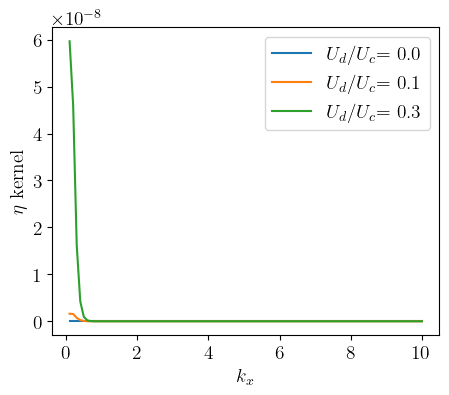

In [6]:
plt.figure(figsize=(5,4))

for i in range(len(Uds)):
    plt.plot(kxar, visc_kx[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [7]:
# eta0 integrand vs kx for 3 values of Ud, at fix sigma and N 

Ntubes = N0
sigma = sigmas[1]

visc_kx = [[] for _ in range(len(Uds))]

for kx in tqdm(kxar):
    for i, ud in enumerate(Uds):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nb)
        visc_kx[i].append(run_k.eta0(1,Ntubes))

100%|██████████| 100/100 [00:00<00:00, 276.95it/s]


c:\Users\camipolv\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\camipolv\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


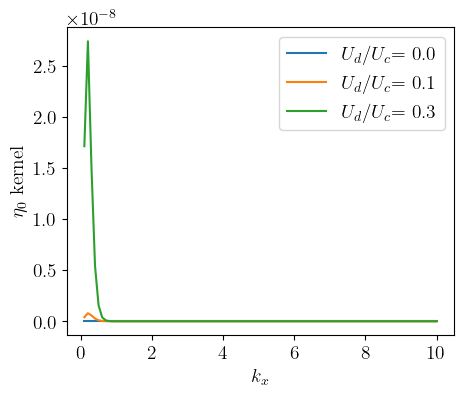

In [8]:
plt.figure(figsize=(5,4))

for i in range(len(Uds)):
    plt.plot(kxar, visc_kx[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta_0$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [9]:
# eta integrand vs kx for 3 values of sigma, at fix Ud and N 

Ntubes = N0
Ud = Uds[1]

visc_kx = [[] for _ in range(len(sigmas))]

for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, Ud, Ndisr, nbs[i])
        visc_kx[i].append(run_k.eta(1,Ntubes))

100%|██████████| 100/100 [00:00<00:00, 494.02it/s]


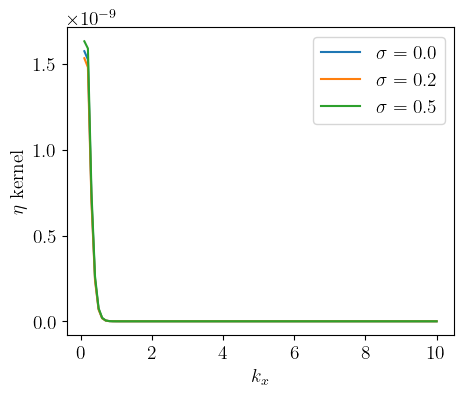

In [10]:
plt.figure(figsize=(5,4))

for i in range(len(sigmas)):
    plt.plot(kxar, visc_kx[i], label=r'$\sigma={}$'.format(sigmas[i]))

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [11]:
# eta0 integrand vs kx for 3 values of sigma, at fix Ud and N 

Ntubes = N0
Ud = Uds[1]

visc_kx = [[] for _ in range(len(sigmas))]

for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, Ud, Ndisr, nbs[i])
        visc_kx[i].append(run_k.eta0(1,Ntubes))

100%|██████████| 100/100 [00:00<00:00, 419.18it/s]


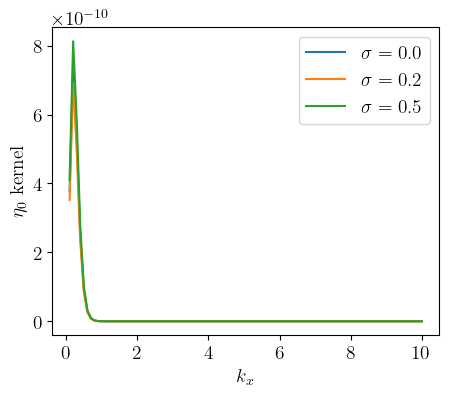

In [12]:
plt.figure(figsize=(5,4))

for i in range(len(sigmas)):
    plt.plot(kxar, visc_kx[i], label=r'$\sigma={}$'.format(sigmas[i]))

plt.xlabel(r"$k_x$", fontsize=14)
plt.ylabel(r"$\eta_0$ kernel", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [13]:
# eta vs Ud/Uc for 3 values of sigma, at fixed N

Ntubes = N0

visc_u = [[] for _ in range(len(sigmas))]

for ud in tqdm(Udar):
    for i,s in enumerate(sigmas):
        visc_kx = [[] for _ in range(len(sigmas))]
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nbs[i])
            visc_kx[i].append(run_k.eta(1, Ntubes))
        visc_u[i].append(np.trapz(visc_kx[i], kxar))

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


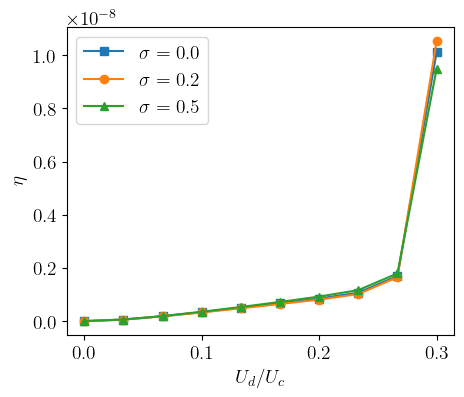

In [14]:
plt.figure(figsize=(5,4))

for i in range(len(visc_u)):
    plt.plot(Udar, visc_u[i], label=r'$\sigma = {}$'.format(sigmas[i]), marker=markers[i])

plt.xlabel(Ust+Ucs, fontsize=14)
plt.ylabel(r"$\eta$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [15]:
# eta vs sigma for for 3 values of Ud, at fixed Ntubes

Ntubes = N0

visc_s = [[] for _ in range(len(Uds))]

for i,s in enumerate(Sigmar):
    visc_kx = [[] for _ in range(len(Uds))]
    for j,u in enumerate(Uds):
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nbars[i])
            visc_kx[j].append(run_k.eta(1, Ntubes))
        visc_s[j].append(np.trapz(visc_kx[j], kxar))

100%|██████████| 100/100 [00:00<00:00, 669.01it/s]


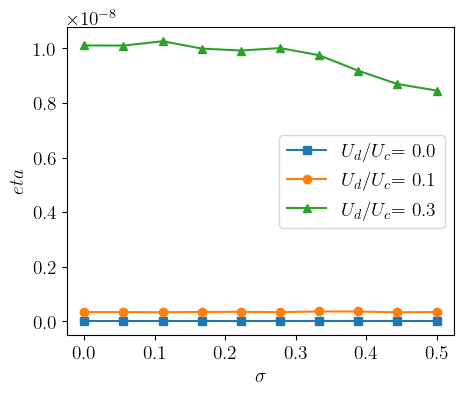

In [16]:
plt.figure(figsize=(5,4))

for i in range(len(visc_s)):
    plt.plot(Sigmar, visc_s[i], label=Ust+Ucs+r'= {}'.format(Uds[i]), marker=markers[i])

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r"$eta$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [17]:
# eta0 vs Ud/Uc for 3 values of sigma, at fixed N

Ntubes = N0

visc_u = [[] for _ in range(len(sigmas))]

for ud in tqdm(Udar):
    for i,s in enumerate(sigmas):
        visc_kx = [[] for _ in range(len(sigmas))]
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nbs[i])
            visc_kx[i].append(run_k.eta0(1, Ntubes))
        visc_u[i].append(np.trapz(visc_kx[i], kxar))

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


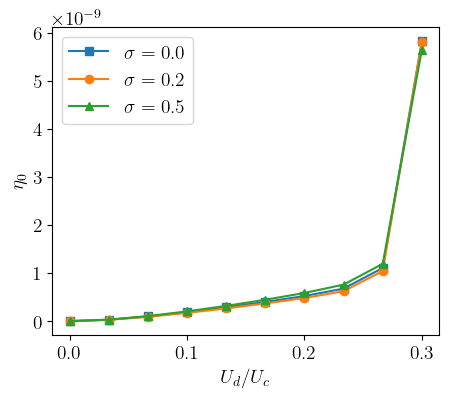

In [18]:
plt.figure(figsize=(5,4))

for i in range(len(visc_u)):
    plt.plot(Udar, visc_u[i], label=r'$\sigma = {}$'.format(sigmas[i]), marker=markers[i])

plt.xlabel(Ust+Ucs, fontsize=14)
plt.ylabel(r"$\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [19]:
# eta0 vs sigma for for 3 values of Ud, at fixed Ntubes
Ntubes = N0

visc_s = [[] for _ in range(len(Uds))]

for i,s in enumerate(Sigmar):
    visc_kx = [[] for _ in range(len(Uds))]
    for j,u in enumerate(Uds):
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nbars[i])
            visc_kx[j].append(run_k.eta0(1, Ntubes))
        visc_s[j].append(np.trapz(visc_kx[j], kxar))

100%|██████████| 100/100 [00:00<00:00, 1062.15it/s]


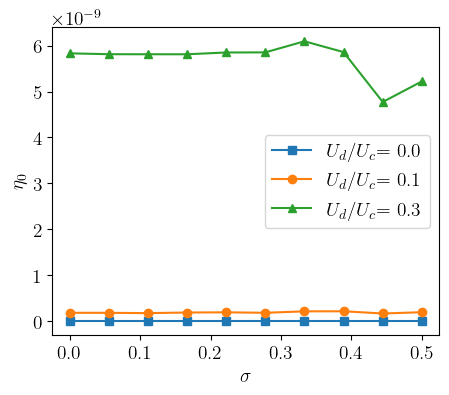

In [20]:
plt.figure(figsize=(5,4))

for i in range(len(visc_s)):
    plt.plot(Sigmar, visc_s[i], label=Ust+Ucs+r'= {}'.format(Uds[i]), marker=markers[i])

plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel(r"$\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [47]:
# eta vs t for 3 Ud, at fix sigma and N

Ntubes = N0
sigma = sigmas[1]

eta_3u = [[] for _ in range(len(Uds))]
etat_3u = [[] for _ in range(len(Uds))]
visc0_kx = [[] for _ in range(len(Uds))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(Uds))]

# Precompute visc0_kx
for i, u in enumerate(Uds):
    for kx in tqdm(kxar):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nb)
        visc0_kx[i].append(run_k.eta0(1, Ntubes))

# Precompute visc_kx for all t and u
for j, u in enumerate(Uds):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nb)
            visc_kx_all[j][i].append(run_k.etat(1, Ntubes, t))

# Compute eta_3u and etat_3u
for j, u in enumerate(Uds):
    for i, t in enumerate(tdar):
        eta_3u[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[1], kxar))
        etat_3u[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 100/100 [00:00<00:00, 619.35it/s]


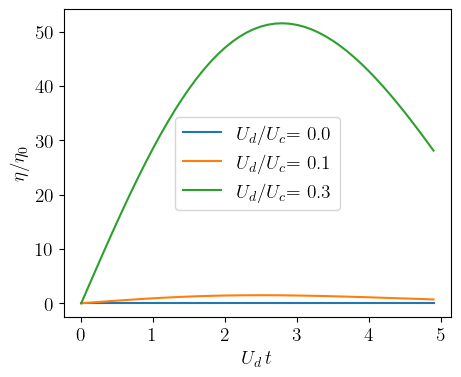

In [48]:
plt.figure(figsize=(5,4))

for i in range(len(etat_3u)):
    plt.plot(tdar, eta_3u[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))

plt.xlabel(Ust+r"$\,t$", fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [49]:
# eta vs t for 3 sigma, fixed Ud and N

Ntubes = N0
Ud = Uds[1]

eta_3s = [[] for _ in range(len(sigmas))]
etat_3s = [[] for _ in range(len(sigmas))]
visc0_kx = [[] for _ in range(len(sigmas))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(sigmas))]

# Precompute visc0_kx
for i, s in enumerate(sigmas):
    for kx in tqdm(kxar):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, Ud, Ndisr, nbs[i])
        visc0_kx[i].append(run_k.eta0(1, Ntubes))

# Precompute visc_kx for all t and s
for j, u in enumerate(sigmas):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nbs[j])
            visc_kx_all[j][i].append(run_k.etat(1, Ntubes, t))

# Compute eta_3s and etat_3s
for j, s in enumerate(sigmas):
    for i, t in enumerate(tdar):
        eta_3s[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[1], kxar))
        etat_3s[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 100/100 [00:00<00:00, 894.68it/s]


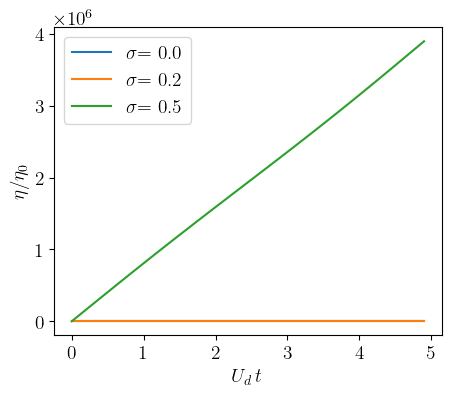

In [51]:
plt.figure(figsize=(5,4))

for i in range(len(etat_3s)):
    plt.plot(tdar, eta_3s[i], label=r'$\sigma$= {}'.format(sigmas[i]))

plt.xlabel(Ust+r"$\,t$", fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

In [52]:
# eta vs t for all n<N, at fixed Ud, sigma and N

Ntubes = N0
ntar = list(range(2, N0 + 1)) if N0 > 2 else [2]
Ud = Uds[1]

eta_n = [[] for _ in range(len(ntar))]
etat_n = [[] for _ in range(len(ntar))]
visc0_kx = [[] for _ in range(len(ntar))]
visc_kx_all = [[[] for _ in range(len(tdar))] for _ in range(len(ntar))]

# Precompute visc0_kx
for i, n in enumerate(ntar):
    for kx in tqdm(kxar):
        run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nb)
        visc0_kx[i].append(run_k.eta0(1, n))

# Precompute visc_kx for all t and n
for j, n in enumerate(ntar):
    for i, t in enumerate(tdar):
        for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, ud, Ndisr, nb)
            visc_kx_all[j][i].append(run_k.etat(1, n, t))

# Compute eta_n and etat_n
for j, n in enumerate(ntar):
    for i, t in enumerate(tdar):
        eta_n[j].append(np.trapz(visc_kx_all[j][i], kxar) / np.trapz(visc0_kx[j], kxar))
        etat_n[j].append(np.trapz(visc_kx_all[j][i], kxar))

100%|██████████| 100/100 [00:00<00:00, 853.81it/s]


In [2]:
plt.figure(figsize=(5,4))

for i in range(len(etat_n)):
    plt.plot(tdar, etat_n[i], label=f'n = {ntar[i]}', marker=markers[i])

plt.xlabel(r't', fontsize=14)
plt.ylabel(r"$\eta/\eta_0$", fontsize=14)
plt.legend(loc='best', fontsize=14)

plt.show()

NameError: name 'plt' is not defined

In [1]:
print(ntar)
print(eta_n)

NameError: name 'ntar' is not defined

In [ ]:
'''# fourier transform of eta vs omega for 3 values of Ud, at fixed Ntubes and sigma

Ntubes = N0
sigma = sigmas[1]
nb = np.random.uniform(1-sigma, 1+sigma, Ntubes)

gamma = 0.01

odar = np.arange(-20, 20, .02)

visc_or= [[], [], []]
visc_oi= [[], [], []]

# Create a list to store the dipolarBEC objects
runs = [[] for _ in range(len(Uds))]

# Create the dipolarBEC objects before the t loop
for i, u in enumerate(Uds):
    for kx in tqdm(kxar):
            run_k = dipolarBECnb.dipolarBECnb(Ntubes, kx, Uc, u, Ndisr, nb)
            runs[i].append(run_k)

for o in tqdm(odar):
    visc_kx = [[], [], []]
    for i, ud in enumerate(Uds):
        for j, kx in tqdm(kxar):
            run_k = runs[i][j]
            visc_kx[i].append(run_k.etaom(1, Ntubes, o, nb, gamma))
        visc_or[i].append(np.real(np.trapz(visc_kx[i], kxar)))
        visc_oi[i].append(np.imag(np.trapz(visc_kx[i], kxar)))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

for i in range(len(visc_or)):
    ax1.plot(odar, visc_or[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))
    ax2.plot(odar, visc_oi[i], label=Ust+Ucs+r'= {}'.format(Uds[i]))

ax1.set_xlabel(r"$\omega$")
ax1.set_ylabel(r"$\tilde{\eta}$, Re")
ax2.set_xlabel(r"$\omega$")
ax2.set_ylabel(r"$\tilde{\eta}$, Im")
plt.legend(loc='best')
fig.tight_layout()

plt.show()'''